In [1]:
import itertools
import os
import json
import copy
import sys
from collections import defaultdict
import itertools
import pandas as pd
from tqdm.notebook import tqdm
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn import linear_model
import seaborn as sns
import random
import seaborn as sns
import scipy.stats as stats
import pandas as pd
#import seaborn as sns
import seaborn as sns
from matplotlib import rcParams
import scipy
from scipy import stats
import seaborn as sns
from scipy import stats
import sys
import seaborn as sns
from utils import *
import numpy as np
pd.set_option('display.max_rows', 500)

In [2]:
AVAILBLE_DATASETS = ['DIALOG_pc.csv','DIALOG_tc.csv','FLICKR.csv','MLQE.csv','REAL_SUM.csv',
                     'SUM_EVAL.csv','TAC_08.csv','TAC_09.csv','TAC_11.csv']
data_path = 'final_df'
ds = 'TAC_11.csv'

# Analysis by Systems 

### Build Borda Count

In [3]:
considered_df_system = pd.read_csv(os.path.join(data_path,ds)).set_index(['System','Utterance'])
assert considered_df_system.shape[0] % considered_df_system.loc[0].shape[0] == 0
nbs_system = considered_df_system.shape[0] // considered_df_system.loc[0].shape[0] 
nbs_utt = considered_df_system.loc[0].shape[0] 

In [4]:
nbs_system,nbs_utt

(44, 54)

In [5]:
dic = {}

for column in list(considered_df_system.columns):
    print(column)
    dic['borda_{}'.format(column)] = []
    for i in range(nbs_system): 
        current_borda_count = np.argsort(np.argsort(considered_df_system.loc[i][column].values)).tolist()
        dic['borda_{}'.format(column)] += current_borda_count
dic['System'] = sum([['M{}'.format(i)]*nbs_utt for i in range(nbs_system)],[])
dic['Utt'] = sum([['U{}'.format(i) for i in range(nbs_utt)]* nbs_system],[])

H:pyr
H:resp
S3_pyr
S3_resp
ROUGE_WE_1
ROUGE_WE_2
JS_1
JS_2
ROUGE_L
ROUGE_1
ROUGE_2
BLEU
Chrfpp
BERTScore
MoverScore


In [6]:
df_borda_system = pd.DataFrame(dic).set_index('System')
df_borda_system.head()
human_metric = [ i for i in df_borda_system.columns if ('H:' in i and 'Utt' not in i)]
other_metric = [ i for i in df_borda_system.columns if ('H:' not in i and 'Utt' not in i)]
print("Human", human_metric)
print("Other", other_metric)

Human ['borda_H:pyr', 'borda_H:resp']
Other ['borda_S3_pyr', 'borda_S3_resp', 'borda_ROUGE_WE_1', 'borda_ROUGE_WE_2', 'borda_JS_1', 'borda_JS_2', 'borda_ROUGE_L', 'borda_ROUGE_1', 'borda_ROUGE_2', 'borda_BLEU', 'borda_Chrfpp', 'borda_BERTScore', 'borda_MoverScore']


### Build training set

In [7]:
X_train = df_borda_system[other_metric].values
y_train = df_borda_system[human_metric].values

In [8]:
X_train.shape,y_train.shape,y_train[:,0].shape

((2376, 13), (2376, 2), (2376,))

In [9]:
assert len(X_train) == len(y_train)

In [22]:
np.logspace(0,2,num=20)

array([  1.        ,   1.27427499,   1.62377674,   2.06913808,
         2.6366509 ,   3.35981829,   4.2813324 ,   5.45559478,
         6.95192796,   8.8586679 ,  11.28837892,  14.38449888,
        18.32980711,  23.35721469,  29.76351442,  37.92690191,
        48.32930239,  61.58482111,  78.47599704, 100.        ])

In [31]:
res = {'coeff': [],"intercept": [],"alpha": []}
index_metric = 0
assert index_metric in range(0,len(human_metric))
for alpha in [10**i for i in [-4,-3,-2,-1,0,1,2,3,4]] : #range(0,100,10):
    if alpha == 0:
        clf = linear_model.LinearRegression(positive = False)
    else: 
        clf = linear_model.Lasso(alpha=alpha,positive = False)
    clf.fit(X_train,y_train[:,index_metric])
    res['coeff'].append(clf.coef_.tolist())
    res['alpha'].append(alpha/10)
    res['intercept'].append(clf.intercept_)

/Users/colombo/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43979.10440262921, tolerance: 57.717000000000006
  model = cd_fast.enet_coordinate_descent(
/Users/colombo/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1822.2472528543149, tolerance: 57.717000000000006
  model = cd_fast.enet_coordinate_descent(


Text(114.0, 0.5, 'Sparsity Coefficient')

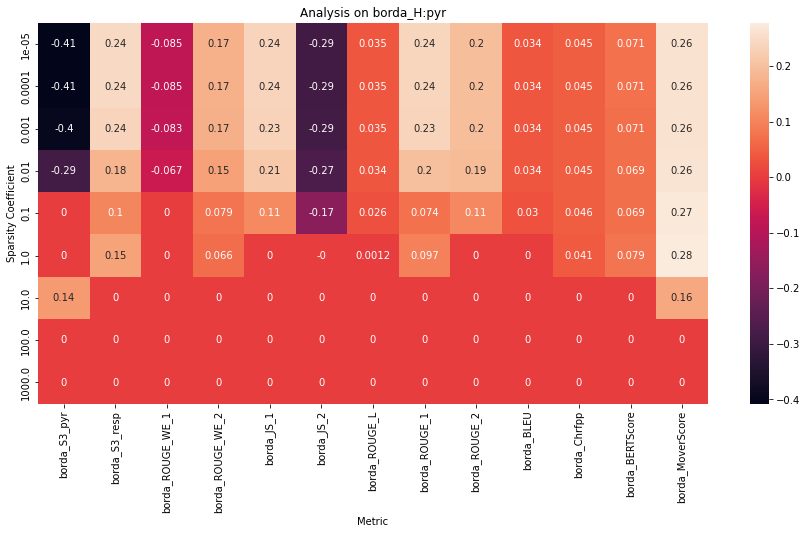

In [32]:
plt.figure(figsize=(15,7))
ax = sns.heatmap(np.array(res['coeff']), annot=True,yticklabels=res['alpha'],xticklabels=other_metric)

plt.title('Analysis on {}'.format(human_metric[index_metric]))
ax.set_xlabel('Metric')
ax.set_ylabel('Sparsity Coefficient')

# Analysis by utterance 

In [34]:
considered_df_utterance = pd.read_csv(os.path.join(data_path,ds)).set_index(['Utterance','System'])
assert considered_df_utterance.shape[0] % considered_df_utterance.loc['M0'].shape[0] == 0
nbs_utt = considered_df_utterance.shape[0] // considered_df_utterance.loc['M0'].shape[0] 
nbs_system = considered_df_utterance.loc['M0'].shape[0] 

In [35]:
nbs_system,nbs_utt

(44, 54)

In [36]:
dic_utterance = {}

for column in list(considered_df_utterance.columns):
    print(column)
    dic_utterance['borda_{}'.format(column)] = []
    for i in range(nbs_utt): 
        current_borda_count = np.argsort(np.argsort(
            considered_df_utterance.loc['M{}'.format(i)][column].values)).tolist()
        dic_utterance['borda_{}'.format(column)] += current_borda_count

H:pyr
H:resp
S3_pyr
S3_resp
ROUGE_WE_1
ROUGE_WE_2
JS_1
JS_2
ROUGE_L
ROUGE_1
ROUGE_2
BLEU
Chrfpp
BERTScore
MoverScore


In [37]:
dic_utterance['System'] = sum([['M{}'.format(i) for i in range(nbs_system)]*nbs_utt],[]) # TODO : pas sur
dic_utterance['Utt'] = sum([['U{}'.format(i)]* nbs_utt  for i in range(nbs_system)],[])
df_borda_utterance = pd.DataFrame(dic_utterance).set_index('Utt')

In [38]:
human_metric = [ i for i in df_borda_utterance.columns if ('H:' in i and 'System' not in i)]
other_metric = [ i for i in df_borda_utterance.columns if ('H:' not in i and 'System' not in i)]
print("Human", human_metric)
print("Other", other_metric)

Human ['borda_H:pyr', 'borda_H:resp']
Other ['borda_S3_pyr', 'borda_S3_resp', 'borda_ROUGE_WE_1', 'borda_ROUGE_WE_2', 'borda_JS_1', 'borda_JS_2', 'borda_ROUGE_L', 'borda_ROUGE_1', 'borda_ROUGE_2', 'borda_BLEU', 'borda_Chrfpp', 'borda_BERTScore', 'borda_MoverScore']


### Building Training set

In [39]:
X_train_utterance = df_borda_utterance[other_metric].values
y_train_utterance = df_borda_utterance[human_metric].values

In [40]:
X_train_utterance.shape,y_train_utterance.shape,y_train_utterance[:,0].shape

((2376, 13), (2376, 2), (2376,))

In [41]:
res_utterance = {'coeff': [],"intercept": [],"alpha": []}
index_metric = 1
assert index_metric in range(0,len(human_metric))
for alpha in [10**i for i in [-4,-3,-2,-1,0,1,2,3,4]] :
    if alpha == 0:
        clf = linear_model.LinearRegression(positive = False)
    else: 
        clf = linear_model.Lasso(alpha=alpha,positive = False)
    clf.fit(X_train_utterance,y_train_utterance[:,index_metric])
    res_utterance['coeff'].append(clf.coef_.tolist())
    res_utterance['alpha'].append(alpha/10)
    res_utterance['intercept'].append(clf.intercept_)

Text(114.0, 0.5, 'Sparsity Coefficient')

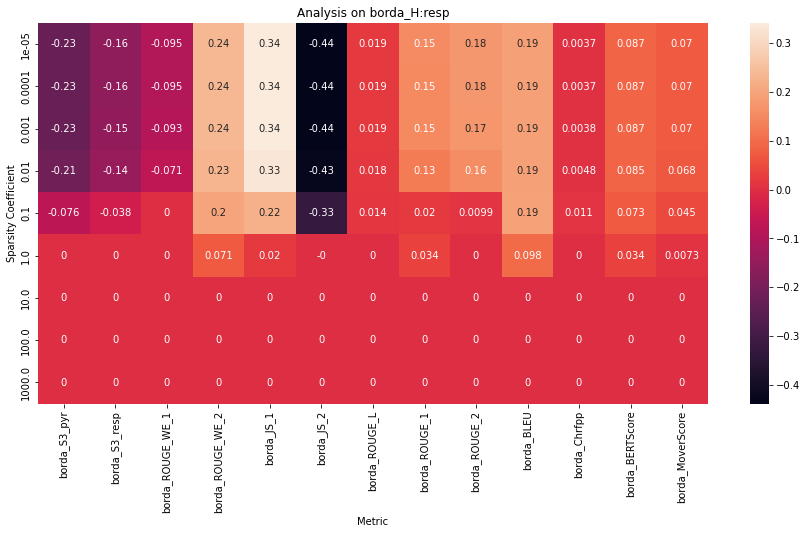

In [42]:
plt.figure(figsize=(15,7))
ax = sns.heatmap(np.array(res_utterance['coeff']), 
                 annot=True,yticklabels=res_utterance['alpha'],xticklabels=other_metric)

plt.title('Analysis on {}'.format(human_metric[index_metric]))
ax.set_xlabel('Metric')
ax.set_ylabel('Sparsity Coefficient')